---
# <font color='blue'> Case Study 3 </font>


## <font color='blue'>Group</font>
* Helene Barrera
* Sam Vonpaays Soh
* Justin Ehly

## <font color='blue'>Business Understanding</font>
- The objective of this project is to build an email spam classifier using Naive Bayes and clustering methods.
- Since there is no inherent structured dataset we will rely on raw email messages from 5 separate folders that are pre-classified as either spam or ham (not spam). 
- From an educational standpoint, this type of work/ exercise is important because often in data science we will experience unstructured data that needs to be structured, mined for meaning and ultimately in this case provide a benefit to end users by classifying emails as spam or not spam.
- From a business standpoint, it's important to gain insight on the types of spam the company might recieve and what may differentiate that from real emails. Spam filters are important because they allow employees to not loose their important emails in a sea of spam in their inbox, or conversely loose their important emails to the spam folder. 

---

## <font color='blue'>Modeling Preparations</font>
- Which methods are you proposing to utilize to solve the problem?  
    - We will use several methods for this problem since the data set is unstructured. 
    - One approach will be to use the provided classifications to build a more traditional structured dataframe, building features as we go. We can use this for exploratory analysis, and to build a simple Kmeans classifier for clustering. Theorectically we could use this with other structured classification methods, however that is outside the scope of this project.
    - We will also form a more complex KMeans model using the raw text from the emails that has been cleaned and run through TF-IDF. This will attempt to cluster the data on the sparse dataset of words. 
    - We will also use a Naive Bayes classifier to determine if an email is spam or ham. For comparison we will do one with the results of the complex KMeans model and one without.

- Why is this method appropriate given the business objective? 
    - Unsupervised learning via clustering is frequently used with text data due to the unstructured nature of the data. The clusters are a way to make sense of the massive amounts of data by forming groups that share similarities that may not be immediately apparent to the human eye.
    - Naive Bayes classifiers work well with text classification and as a spam filter. The algorithm is fast due to its lack of complication compared to logistic regression, but logistic regression will tend to get better performance scores due to its more complicated algorithm. For email classification, we tend to lean more towards quick deployment so the classifier can work in real-time and be updated on a regular basis. 
    
- How will you determine if your approach is useful (or how will you differentiate which approach is more useful than another)? 
    - Since it is unstructured data, we can gleen some insight just from visually comparing clusters. 
    - An approach that can be implemented with less computational time and complexity that has the highest sucess rate at filtering out spam without filtering out too many important emails will be the most useful.

- More specifically, what evaluation metrics are most useful given that the problem is a classification one (ex., F1-score, Accuracy, AUC, etc.)?
    - For KMeans, we will specifically look at the inertia and homogeneity to choose the appropriate number of clusters (primarily using the Elbow Method). To evaluate our final model, we will visually assess the model and use 
    - For Naive Bayes, we will use accuracy, precision and recall, with the intent to maximize accuracy, since getting the most correct is the most important thing. (Classifying incorrectly either way will have the same functional effect on employee productivity).

## <font color='blue'>Data Engineering</font>
- As stated previously we will be building several models that will require different data clean up and structuring. 
- We begin with forming the structured data frame and adding the following features:
    - is_spam (Y/N whether the email is spam based on the classification given by the directory the email was located in)
    - is_reply (Y/N whether the email is reply based on presence of "Subject: Re:" string
    - subj_caps (Y/N whether the subject line is in all capital letters)
    - attachments (Y/N whether the email contained an attachment)
    - body_lines (Count of the number of lines in the email)
    - word_count (count of the number of words in the email - includes not real words)
    - character_count (count of number of characters in the email)
    - norm_punctuation (Count of the number of times normal punctuation appears in the email including . , )
    - other_punctuation (Count of the number of times other punctuation appears in the email including ! ? # % )
    - readability (Uses the Flesch-Kincaid readability test to determine complexity of the content of the email)
- The exploratory data analysis was done soley on this data - interpretations and takeaways will be provided under each graph and section.

In [1]:
import os
from os import listdir, getcwd, chdir
from os.path import isfile, join, dirname, realpath
import glob
import numpy as np
import pandas as pd
import email
import textstat

#os.chdir('C:/Users/justi/Google Drive/_SMU/7333 - Quantifying the World/Case Study 3')
chdir('D:\\MS in Data Science\\Quantifying\\Case Study 3')

getcwd()

'D:\\MS in Data Science\\Quantifying\\Case Study 3'

In [2]:
# Sam's mapping
#easy_ham=glob.glob('Case 3_SpamAssassinMessages/easy_ham/*')
#easy_ham_2=glob.glob('Case 3_SpamAssassinMessages/easy_ham_2/*')
#hard_ham=glob.glob('Case 3_SpamAssassinMessages/hard_ham/*')
#spam=glob.glob('Case 3_SpamAssassinMessages/spam/*')
#spam_2=glob.glob('Case 3_SpamAssassinMessages/spam_2/*')

# Justin and Helene mapping
easy_ham=glob.glob('SpamAssassinMessages/easy_ham/*')
easy_ham_2=glob.glob('SpamAssassinMessages/easy_ham_2/*')
hard_ham=glob.glob('SpamAssassinMessages/hard_ham/*')
spam=glob.glob('SpamAssassinMessages/spam/*')
spam_2=glob.glob('SpamAssassinMessages/spam_2/*')

In [3]:
#Read the text files in from the directories
#Run a for loop to get various features of interest and store them as columns in a new dataframe 

def get_cwd():
    try:
        chdir(dirname(realpath(__file__)))
    except:
        #Change pathing here
        chdir('D:\\MS in Data Science\\Quantifying\\Case Study 3')

    active_dir = getcwd() 
    return active_dir

def main():  
    get_cwd()
    
    directories = [
            'easy_ham',
            'easy_ham_2',
            'hard_ham',
            'spam',
            'spam_2'   
        ]
    
    
    features = pd.DataFrame()
        
    for d in directories:
        #May need to edit this path too
        mypath = getcwd() + '\\SpamAssassinMessages\\' + d + '\\'
        onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    
        try:
            onlyfiles.remove('.DS_Store')
        except:
            pass
        
        for file in onlyfiles:
            with open(mypath + file, encoding='latin1') as f:
                lines = f.readlines()
                f.close()
                
            in_reply_count = 0
            sub_line_all_caps = 0
            attachments = 0
            subject_line = []
            n_lines = 0
            blank_lines = [0]
            number_of_words = 0
            number_of_characters = 0
            norm_counter = 0 
            norm_punctuation = 0
            other_punctuation = 0
            period = 0
            comma = 0
            exclam = 0
            question = 0
            dollar = 0
            percent = 0
            
            readability = textstat.flesch_reading_ease(file)
                        
            for line in lines:
                n_lines += 1
                words = line.split()
                number_of_words += len(words)
                number_of_characters += len(line)
                
                if "Subject: Re: " in line:
                    in_reply_count += 1
                if "Subject: " in line:
                    s_line = line.strip().replace('Subject: ','')
                    s_line = ''.join(e for e in s_line if e.isalnum())
                    num_upper = sum(1 for c in s_line if c.isupper())
                    ttl_chars = len(s_line)
                    if num_upper == ttl_chars:
                        sub_line_all_caps += 1
                    subject_line.append(s_line)
                if "content-type: multipart" in line.lower():
                    attachments += 1
                if line == "\n":
                    blank_lines.append(n_lines)
                if "." or "," in line:
                    period = line.count('.')
                    comma = line.count(',')
                    norm_counter = period + comma
                    norm_punctuation += norm_counter
                if "!" or "?" or "$" or "%" in line:
                    exclam = line.count('!')
                    question = line.count('?')
                    dollar = line.count('$')
                    percent = line.count('%')
                    other_counter = exclam + question + dollar + percent
                    other_punctuation += other_counter
                    
              
            temp_frame = pd.DataFrame({
                        'filename':file,
                        'is_spam':['Y' if 'spam' in d else 'N'],
                        'is_reply': ['Y' if in_reply_count > 0 else 'N'], 
                        'subj_caps': ['Y' if sub_line_all_caps > 0 else 'N'], 
                        'attachments': ['Y' if attachments > 0 else 'N'], 
                        'body_lines': n_lines - min(blank_lines),
                        'word_count' : number_of_words,
                        'character_count' : number_of_characters,
                        'norm_punctuation' : norm_punctuation,
                        'other_punctuation' : other_punctuation,
                        'readability' : readability
                        }, index=[0])
           
            features = features.append(temp_frame, ignore_index=True)
            
    features.to_csv('output_file.csv', index=False)
    
    return features


##Main Function##

if __name__ == "__main__":
    features = main()
    pass        
       

In [4]:
features.head()

,filename,is_spam,is_reply,subj_caps,attachments,body_lines,word_count,character_count,norm_punctuation,other_punctuation,readability
0,00001.7c53336b37003a9286aba55d2945844c,N,Y,N,N,113,499,5216,255,6,121.22
1,00002.9c4069e25e1ef370c078db7ee85ff9ac,N,N,N,N,73,338,3376,118,3,-132.59
2,00003.860e3c3cee1b42ead714c5c874fe25f7,N,N,N,N,82,464,3934,122,2,36.62
3,00004.864220c5b6930b209cc287c361c99af1,N,N,N,N,78,377,3424,130,3,36.62
4,00005.bf27cdeaf0b8c4647ecd61b1d09da613,N,Y,N,N,77,366,3386,132,3,-47.99


#### Data Visualization

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

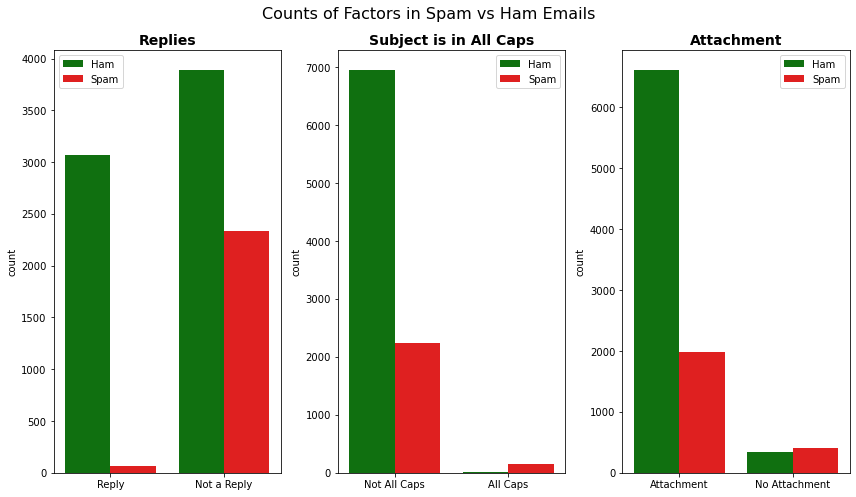

In [6]:
fig, axes = plt.subplots(1, 3, figsize = (12, 7))

fig.suptitle("Counts of Factors in Spam vs Ham Emails", fontsize = 16)

sns.countplot(ax = axes[0], x="is_reply", data=features, hue = "is_spam", palette = ["green", "red"])
axes[0].set_title("Replies", fontsize=14, fontweight='bold')
axes[0].set_xlabel(None)
axes[0].set_xticklabels(["Reply", "Not a Reply"])
axes[0].legend(title = None , labels = ["Ham", "Spam"])

sns.countplot(ax = axes[1], x="subj_caps", data=features, hue = "is_spam", palette = ["green", "red"])
axes[1].set_title("Subject is in All Caps", fontsize=14, fontweight='bold')
axes[1].set_xlabel(None)
axes[1].set_xticklabels(["Not All Caps", "All Caps"])
axes[1].legend(title = None , labels = ["Ham", "Spam"])

sns.countplot(ax = axes[2], x="attachments", data=features, hue = "is_spam", palette = ["green", "red"])
axes[2].set_title("Attachment", fontsize=14, fontweight='bold')
axes[2].set_xlabel(None)
axes[2].set_xticklabels(["Attachment", "No Attachment"])
axes[2].legend(title = None , labels = ["Ham", "Spam"])

plt.tight_layout()

##### Interpretation of Factor Counts

<b>Replies: </b>   
    - We can see that the vast majority of emails are NOT replies.    
    - Very few spam emails are also replies, which makes sense because spammers are typically the first to make contact. The spam emails that are replies might have been from employees accidentally responding to the original spam message, and the spammer replying back.    
       
<b>Caps Lock:</b>   
    - Although the total number of emails where the subject line is in all caps are small, it's very telling when they do occur. Hardly any legitamate emails use all caps.   
   
<b>Attachments:</b>      
    - While total number of attachments recieved from spam and ham emails is similar, the ratio of spammers sending attachments appears to be much higher.   

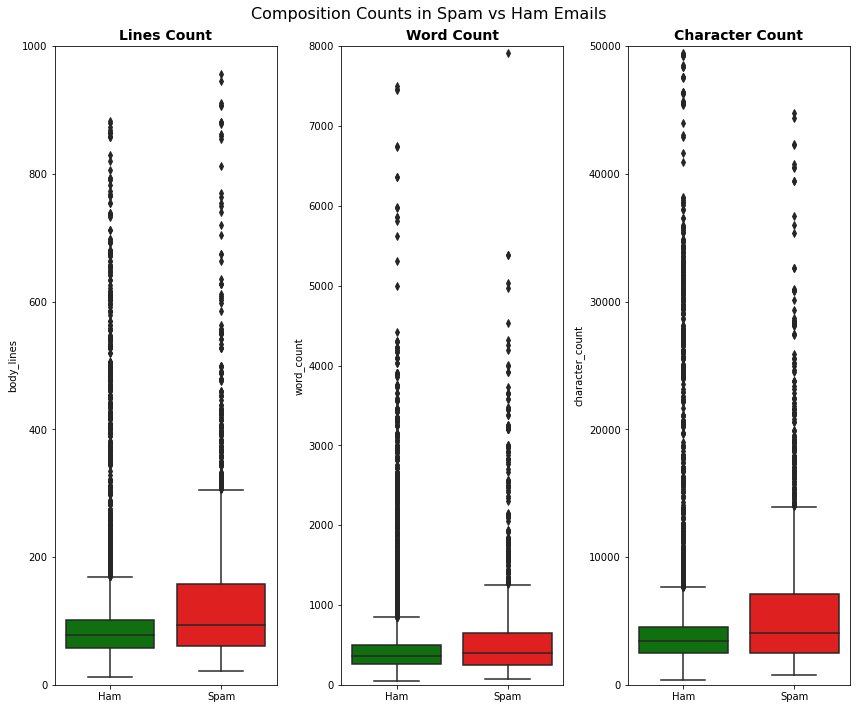

In [7]:
fig, axes = plt.subplots(1, 3, figsize = (12, 10))

fig.suptitle("Composition Counts in Spam vs Ham Emails", fontsize = 16)

sns.boxplot(ax = axes[0], y = "body_lines", x = "is_spam", data = features, palette = ["green", "red"])
axes[0].set_ylim([0,1000])
axes[0].set_title("Lines Count", fontsize=14, fontweight='bold')
axes[0].set_xlabel(None)
axes[0].set_xticklabels(["Ham", "Spam"])

sns.boxplot(ax = axes[1], y = "word_count", x = "is_spam", data = features, palette = ["green", "red"])
axes[1].set_ylim([0,8000])
axes[1].set_title("Word Count", fontsize=14, fontweight='bold')
axes[1].set_xlabel(None)
axes[1].set_xticklabels(["Ham", "Spam"])

sns.boxplot(ax = axes[2], y = "character_count", x = "is_spam", data = features, palette = ["green", "red"])
axes[2].set_ylim([0,50000])
axes[2].set_title("Character Count", fontsize=14, fontweight='bold')
axes[2].set_xlabel(None)
axes[2].set_xticklabels(["Ham", "Spam"])

plt.tight_layout()

##### Interpretation of Composition Counts   
Note that some extreme outliers were cut from this visual in favor of examining the main distributions more closely. 

These graphs all tell us that on avarage spam and ham emails have a similar amount of lines, words, and characters, although the spam distribution has a slightly larger spread, meaning a decent chunk of spam emails are significantly longer than your average ham email. 


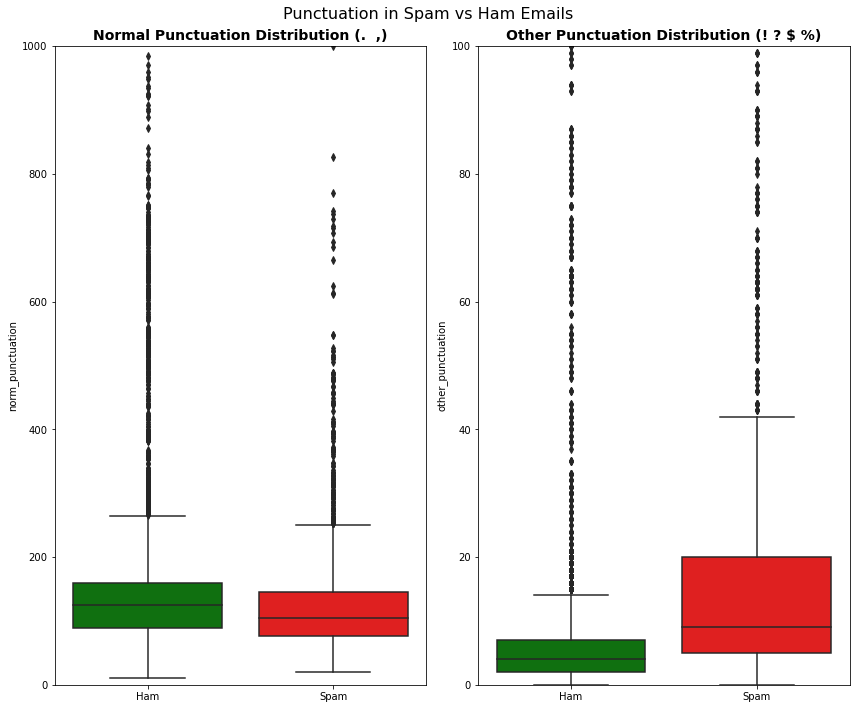

In [8]:
fig, axes = plt.subplots(1, 2, figsize = (12, 10))
fig.suptitle("Punctuation in Spam vs Ham Emails", fontsize = 16)

sns.boxplot(ax = axes[0], y = "norm_punctuation", x = "is_spam", data = features, palette = ["green", "red"])
axes[0].set_ylim([0,1000])
axes[0].set_title("Normal Punctuation Distribution (.  ,)", fontsize=14, fontweight='bold')
axes[0].set_xlabel(None)
axes[0].set_xticklabels(["Ham", "Spam"])


sns.boxplot(ax = axes[1], y = "other_punctuation", x = "is_spam", data = features, palette = ["green", "red"])
axes[1].set_ylim([0,100])
axes[1].set_title("Other Punctuation Distribution (! ? $ %)", fontsize=14, fontweight='bold')
axes[1].set_xlabel(None)
axes[1].set_xticklabels(["Ham", "Spam"])

plt.tight_layout()

##### Interpretation of Punctuation

Note that some extreme outliers were cut from this visual in favor of examining the main distributions more closely. 
   
While spam and ham emails have similar levels of normal punctuation, spam emails contain significantly more "other" punctuation. These categories were chosen following a quick spot check comparison of the text in ham vs spam emails. The spam emails seemed to have pleanty of references to sales and making purchases, hence the $ and % signs. 

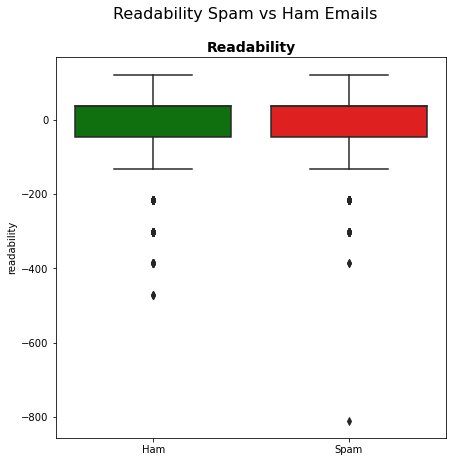

In [9]:
fig, ax = plt.subplots(figsize = (7, 7))
fig.suptitle("Readability Spam vs Ham Emails", fontsize = 16)

sns.boxplot(ax = ax, y = "readability", x = "is_spam", data = features, palette = ["green", "red"])
ax.set_title("Readability", fontsize=14, fontweight='bold')
ax.set_xlabel(None)
ax.set_xticklabels(["Ham", "Spam"])


plt.show()

##### Interpretation of Readability

Interestingly, ham and spam emails had almost the same exact distribution of readability per the Flesch-Kincaid readability scale. This scale is meant to show the relative reading difficulty of a passage of text, with a lower number being much harder to read than a higher number (0 = graduate school, 100 = 5th grader could read). 
The scale was developed for use in academia and does not appear to tranfer well to casual english emails, considering the presence of large negative numbers which are essentially uninterpretable. It's unclear whether this could be inproved by running it following the text clean-up process, but we will just drop it from the analysis.  

### Exploratory Data Analysis Summary

As you can see, even the few factors in our exploratory data analysis produced several key differences that can be used by a clustering model to differentiate between classes. Key differences were the presence of "other" punctuation, a generally longer text document, the designation of reply or not, and the presence of an all capitalized subject line. 

## <font color='blue'>Model Building and Evaluation</font>

### Preparing the non-text features
This is our structured dataframe that will be used to run a KMeans cluster model later.Categorical variables were onehot encoded, while continuous variables were scaled. The is_spam variable was transformed into 0,1 values specifically for visualization purposes later. 

In [10]:
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import copy

In [11]:
#Make a new dataframe to work with and drop target variable and file name
#Dropped readability since it wasn't useful and filename since we won't need that
#Dropped 'is_spam' only from our new dataset

#One Hot Encode categorical variables
df = copy.deepcopy(features)
del df['filename']
del df['readability']

categorical = df[['is_reply', 'subj_caps', 'attachments']]

ohe = OneHotEncoder(sparse = False)
ohe_cat = pd.DataFrame(ohe.fit_transform(categorical), columns = ['not_reply','reply', 'not_caps', 'caps', 'no_attachment', 'attachment'])

#Scale non categorical variables
continuos = df.drop(['is_reply', 'subj_caps', 'attachments', 'is_spam'], axis = 1)

std = StandardScaler()
std_cont = pd.DataFrame(std.fit_transform(continuos), columns = continuos.columns)

#Create numerical binary target variable
y_df = df[['is_spam']]
y_df = y_df.is_spam.eq('Y').mul(1)
y_features = y_df.values

#Merge back into one dataframe (pro_features doesn't have target variable)
pro_features = pd.concat([ohe_cat, std_cont], axis = 1)

all_features = pd.concat([y_df, pro_features], axis = 1)

### Cleaning and preparing the text data

This raw text data will be used in TF-IDF and model building later. Here we did a type of stratified shuffle split on the data to keep the same proportion of spam to ham in our train and test spilts similar. Then the text was stripped of punctuation, unecessary lines and capitalization. We also ran a lemmatizer to combine words that share the same root. 

In [12]:
def email_content(email_path):
    file = open(email_path,encoding='latin1')
    try:
        msg = email.message_from_file(file)
        for part in msg.walk():
            if part.get_content_type() == 'text/plain':
                return part.get_payload() # prints the raw text
    except Exception as e:
        print(e)
        
        
def email_content_bulk(email_paths):
    email_contents = [email_content(i) for i in email_paths]
    return email_contents

In [13]:
ham_group = [easy_ham,easy_ham_2,hard_ham]
spam_group = [spam,spam_2]

In [14]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

ham_train = np.array([])
ham_test = np.array([])
spam_train = np.array([])
spam_test = np.array([])

spam1 = np.array([train_test_split(i) for i in spam_group])
for i in spam1:
    spam_train = np.concatenate((spam_train,i[0]),axis=0)
    spam_test = np.concatenate((spam_test,i[1]),axis=0)

ham1 = np.array([train_test_split(i) for i in ham_group])
for i in ham1:
    ham_train = np.concatenate((ham_train,i[0]),axis=0)
    ham_test = np.concatenate((ham_test,i[1]),axis=0)

In [15]:
ham_train.shape,ham_test.shape,spam_train.shape,spam_test.shape

((5214,), (1740,), (1798,), (601,))

In [16]:
#Train
ham_train_lab = [0]*ham_train.shape[0]
spam_train_lab = [1]*spam_train.shape[0]
x_train = np.concatenate((ham_train,spam_train))
y_train = np.concatenate((ham_train_lab,spam_train_lab))

#Test
ham_test_lab = [0]*ham_test.shape[0]
spam_test_lab = [1]*spam_test.shape[0]
x_test = np.concatenate((ham_test,spam_test))
y_test = np.concatenate((ham_test_lab,spam_test_lab))

In [17]:
train_shuffle = np.random.permutation(np.arange(0,x_train.shape[0]))
test_shuffle = np.random.permutation(np.arange(0,x_test.shape[0]))

In [18]:
train_shuffle, test_shuffle

(array([2360, 1407, 5798, ..., 1001,  585, 2962]),
 array([ 525, 2223,  512, ..., 2189,  516, 1036]))

In [19]:
x_train = x_train[train_shuffle]
y_train = y_train[train_shuffle]
x_test = x_test[test_shuffle]
y_test = y_test[test_shuffle]

In [20]:
y_train.shape

(7012,)

In [21]:
x_train = email_content_bulk(x_train)
x_test = email_content_bulk(x_test)

In [22]:
x_test

["So then, Guido van Rossum <guido@python.org> is all like:\n\n> Maybe.  I batch messages using fetchmail (don't ask why), and adding\n> .4 seconds per message for a batch of 50 (not untypical) feels like a\n> real wait to me...\n\nYeesh.  Sounds like what you need is something to kick up once and score\nan entire mailbox.\n\nWait a second...  So *that's* why you wanted -u.\n\nIf you can spare the memory, you might get better performance in this\ncase using the pickle store, since it only has to go to disk once (but\nboy, does it ever go to disk!)  I can't think of anything obvious to\nspeed things up once it's all loaded into memory, though.  That's\nprofiler territory, and profiling is exactly the kind of optimization\nI just said I wasn't going to do :)\n\nNeale\n",
 None,
 'Ah, THIS is the car i\'ve seen on discovery channel, but url via a lurker.\n\nhttp://arivettracing.com/battery.html\n\n- Adam L. "Duncan" Beberg\n  http://www.mithral.com/~beberg/\n  beberg@mithral.com\n\n\n',
 

In [23]:
x_train1 = x_train
x_test1 = x_test

In [24]:
def removing_null(datas,labels):
    not_null_idx = [i for i,o in enumerate(datas) if o is not None]
    return np.array(datas)[not_null_idx],np.array(labels)[not_null_idx]

In [25]:
x_train,y_train= removing_null(x_train,y_train)
x_test,y_test= removing_null(x_test,y_test)

In [26]:
import re
import string
from nltk.tokenize import word_tokenize
def remove_hyperlink(word):
    return  re.sub(r"http\S+", "", word)
def to_lower(word):
    result = word.lower()
    return result
def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result
def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result
def remove_whitespace(word):
    result = word.strip()
    return result
def replace_newline(word):
    return word.replace('\n','')

def pipeline(sentence):
    cleaning_utils = [remove_hyperlink, to_lower, remove_number, remove_punctuation,remove_whitespace,
                      replace_newline]
    for i in cleaning_utils:
        sentence = i(sentence)
    return sentence

In [27]:
x_train = [pipeline(i) for i in x_train]
x_test = [pipeline(i) for i in x_test]

In [28]:
x_train

['url date not suppliedthe new neiman marcus christmas catalog is out in october including youasanactionfigure  a bamboo hut  and a leather frisbee  link discuss',
 'heres clarification of why i didfirst test results using tokenizertokenizertokenizeheadersunmodified training on  hams   spams                          training on  hams   spams                           training on  hams   spams                           training on  hams   spams                           total false pos  total false neg  second test results using mboxtestmytokenizertokenizeheadersthis uses all headers except received data and xfromtraining on  hams   spams                           training on  hams   spams                           training on  hams   spams                           training on  hams   spams                           total false pos  total false neg  jeremy',
 'congrats in the end if they didnt have max they might have succumbed because paypal was  susceptible to fraud and money launder

In [29]:
# grab the word_tokenize from the natural language toolkit
import nltk
#nltk.download('punkt')
from nltk.tokenize import word_tokenize
%time
x_train = [word_tokenize(i) for i in x_train]
x_test = [word_tokenize(i) for i in x_test]

Wall time: 0 ns


In [30]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def remove_stop_words(words):
    result = [i for i in words if i not in ENGLISH_STOP_WORDS]
    return result

def word_lemmatizer(words):
    return [lemmatizer.lemmatize(i) for i in words]

def token_pipeline(words):
    cleaning_utils = [remove_stop_words, word_lemmatizer]
    for i in cleaning_utils:
        words = i(words)
    return words

In [31]:
#nltk.download('wordnet')
%time
x_train = [token_pipeline(i) for i in x_train]
x_test = [token_pipeline(i) for i in x_test]
x_train = [" ".join(i) for i in x_train]
x_test = [" ".join(i) for i in x_test]

Wall time: 0 ns


### Feature Extraction: TF-IDF
   
Otherwise known as Term Frequency-Inverse Document Frequency, TF-IDF is essential for preparing raw text data for processing and use in models. This process shows how frequently a word appears in a document, but words that appear less frequently throughout all the documents are given more weight and importance than those that appear less frequently in the collection of documents. This data will be cleaned and fed into models later. 

In [32]:
x_train = [i.split(" ") for i in x_train]
x_test = [i.split(" ") for i in x_test]

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf= TfidfVectorizer()
raw_sentences = [' '.join(i) for i in x_train]
tfidf.fit(raw_sentences)

TfidfVectorizer()

In [34]:
def convert_to_feature(raw_tokenize_data):
    raw_sentences = [' '.join(i) for i in raw_tokenize_data]
    return tfidf.transform(raw_sentences)

In [35]:
x_train_features = convert_to_feature(x_train)
x_test_features = convert_to_feature(x_test)

In [36]:
x_train_features.shape,x_test_features.shape

((6035, 92877), (2012, 92877))

In [37]:
import scipy
scipy.sparse.issparse(x_train_features) # check to see if data is sparse

True

## Minibatch Kmeans Using Unstructured Text Data

We decided to use Minibatch KMeans due to the large size of the dataset. Functionally it shouldn't have a much different result than regular KMeans, but it will save us hours when running the process. An iterator was used to test different sizes for number of clusters and batch size, but ultimately the batch size didn't change the results much, so it was set at 500 to reduce computation time. We attempted to use the Elbow Method to choose our optimal cluster size, but with this data, the chart was inconclusive. At least this model can serve to reduced the dimensionality of the original text data. Since there are so many clusters, we will not do any visualiztion for this particular model - instead we will use the results in our Naive Bayes model and compare that to a vanilla model. 

In [38]:
from tqdm import tqdm
from time import time
import time as t
import itertools
from itertools import *
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics

In [39]:
#parameters to try for mini batch k means
n_clusters = [10, 50, 100, 500, 1000, 2000, 3000]
batch_size = [500]


In [40]:
#Make an iterator to try different combinations of parameters for mini batch k means
#Results in the mkm list that contains the MiniBatchKMeans() function with all combinations of parameters
mkm = []

def mkm_iter(n_clusters, batch_size):
    for index, item in enumerate(n_clusters):
        k = item
        #print(k)
        b = 0
        for index, item in enumerate(batch_size):
            b = item
            #print(b)
            mkm_holder = MiniBatchKMeans(
                n_clusters = k, 
                batch_size = b,
                init = 'k-means++', 
                max_iter = 100, 
                n_init = 10, 
                random_state = 42) 
            #print(mkm)
            mkm.append(mkm_holder)

mkm_iter(n_clusters, batch_size)

In [41]:
#iterates through the various MiniBatchKMeans() functions with different parameter combinations
#Fits each model and creates labels and cluster centers for them, and adds those to a list. 
mkm_labels = []
mkm_clusters = []
mkm_uni_labels = []
mkm_inert = []
mkm_xval = []
results = []

for i in mkm:
    #print(i)
    mkm_i = i
    t0 = t.time()
    mkm_i.fit(x_train_features)
    mkm_xval.append(mkm_i)
    mkm_inert.append(mkm_i.inertia_)
    mkm_batch = t.time() - t0
    mkm_labels.extend(mkm_i.labels_)
    mkm_clusters.extend(mkm_i.cluster_centers_)
    mkm_uni_labels.extend(np.unique(mkm_labels))      
    results.append({'clusters': n_clusters,
                    'Homogeneity': metrics.homogeneity_score(y_train, mkm_i.labels_),
                    'Completeness': metrics.completeness_score(y_train, mkm_i.labels_),
                    'V_measure': metrics.v_measure_score(y_train, mkm_i.labels_),
                    'ARI': metrics.adjusted_rand_score(y_train, mkm_i.labels_),
                    'Sil Coef': metrics.silhouette_score(y_train.reshape(-1,1), mkm_i.labels_, sample_size=1000)})

In [42]:
x = 0
for i in mkm:
    print("Combination", x, " : ", i)
    x += 1

Combination 0  :  MiniBatchKMeans(batch_size=500, n_clusters=10, n_init=10, random_state=42)
Combination 1  :  MiniBatchKMeans(batch_size=500, n_clusters=50, n_init=10, random_state=42)
Combination 2  :  MiniBatchKMeans(batch_size=500, n_clusters=100, n_init=10, random_state=42)
Combination 3  :  MiniBatchKMeans(batch_size=500, n_clusters=500, n_init=10, random_state=42)
Combination 4  :  MiniBatchKMeans(batch_size=500, n_clusters=1000, n_init=10, random_state=42)
Combination 5  :  MiniBatchKMeans(batch_size=500, n_clusters=2000, n_init=10, random_state=42)
Combination 6  :  MiniBatchKMeans(batch_size=500, n_clusters=3000, n_init=10, random_state=42)


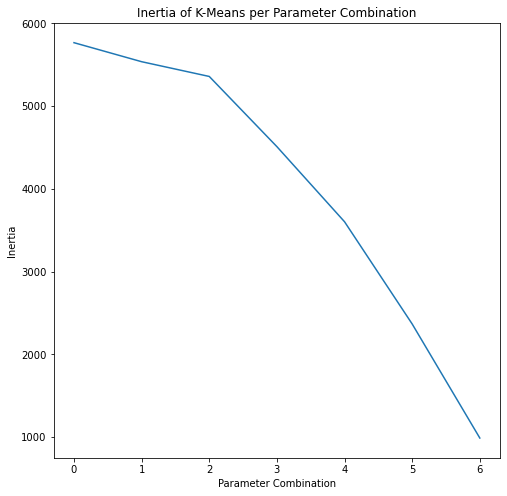

In [43]:
#Plot the inertia from our fitted MiniBatchKMeans() to find the combination of parameters (k-clusters and batch sizes) that results in the lowest inertia
fig, ax = plt.subplots(figsize = (8, 8))

sns.lineplot(range(len(mkm_xval)), mkm_inert)
plt.title('Inertia of K-Means per Parameter Combination')
plt.xlabel('Parameter Combination')
plt.ylabel('Inertia')

x_ticks = np.arange(0, 7, 1)
plt.xticks(x_ticks)

plt.show()

In [44]:
results

[{'clusters': [10, 50, 100, 500, 1000, 2000, 3000],
  'Homogeneity': 0.35525379770900095,
  'Completeness': 0.08953913032173606,
  'V_measure': 0.143028875172043,
  'ARI': 0.019057267044762766,
  'Sil Coef': -0.705},
 {'clusters': [10, 50, 100, 500, 1000, 2000, 3000],
  'Homogeneity': 0.4817520280495651,
  'Completeness': 0.08297380323116074,
  'V_measure': 0.14156532521611084,
  'ARI': 0.00762397273027724,
  'Sil Coef': -0.559},
 {'clusters': [10, 50, 100, 500, 1000, 2000, 3000],
  'Homogeneity': 0.5282199118821617,
  'Completeness': 0.08100574227396547,
  'V_measure': 0.14046961336574829,
  'ARI': 0.04310022382117101,
  'Sil Coef': -0.539},
 {'clusters': [10, 50, 100, 500, 1000, 2000, 3000],
  'Homogeneity': 0.5627992947545343,
  'Completeness': 0.06667504556698442,
  'V_measure': 0.11922541148749183,
  'ARI': 0.007401349043429831,
  'Sil Coef': -0.476},
 {'clusters': [10, 50, 100, 500, 1000, 2000, 3000],
  'Homogeneity': 0.641167899686068,
  'Completeness': 0.05864278707982897,
  'V

## Minibatch Kmeans with Structured Dataframe Features

Using the structured data proved slightly more fruitful - we were able to produce a passable model at around 50 clusters, although optimal was closer to 1000 (that many clusters is functionally usless as stated before.)
   
For the purpose of showing what <b>can</b> be done with cluster data, please see visualizations and interpretations below. 

In [45]:
ln_clusters = [3, 6, 12, 24, 48, 100, 1000]
lbatch_size = [250]

In [46]:
#Same iterator but renamed to avoid code complications
lmkm = []

def lmkm_iter(ln_clusters, lbatch_size):
    for index, item in enumerate(ln_clusters):
        l = item
        m = 0
        for index, item in enumerate(lbatch_size):
            m = item
            lmkm_holder = MiniBatchKMeans(
                n_clusters = l, 
                batch_size = m,
                init = 'k-means++', 
                max_iter = 100, 
                n_init = 10, 
                random_state = 42) 
            lmkm.append(lmkm_holder)

lmkm_iter(ln_clusters, lbatch_size)

In [47]:
lmkm_labels = []
lmkm_clusters = []
lmkm_uni_labels = []
lmkm_inert = []
lmkm_xval = []
lresults = []

for i in lmkm:
    lmkm_i = i
    t0 = t.time()
    lmkm_i.fit(pro_features)
    lmkm_xval.append(lmkm_i)
    lmkm_inert.append(lmkm_i.inertia_)
    lmkm_batch = t.time() - t0
    lmkm_labels.extend(lmkm_i.labels_)
    lmkm_clusters.extend(lmkm_i.cluster_centers_)
    lmkm_uni_labels.extend(np.unique(lmkm_labels))  
    lresults.append({'Parameters': i,
                    'Homogeneity': metrics.homogeneity_score(y_features, lmkm_i.labels_),
                    'Completeness': metrics.completeness_score(y_features, lmkm_i.labels_),
                    'V_measure': metrics.v_measure_score(y_features, lmkm_i.labels_),
                    'ARI': metrics.adjusted_rand_score(y_features, lmkm_i.labels_),
                    'Sil Coef': metrics.silhouette_score(y_features.reshape(-1,1), lmkm_i.labels_, sample_size=1000)})

In [48]:
x = 0
for i in lmkm:
    print("Combination", x, " : ", i)
    x += 1

Combination 0  :  MiniBatchKMeans(batch_size=250, n_clusters=3, n_init=10, random_state=42)
Combination 1  :  MiniBatchKMeans(batch_size=250, n_clusters=6, n_init=10, random_state=42)
Combination 2  :  MiniBatchKMeans(batch_size=250, n_clusters=12, n_init=10, random_state=42)
Combination 3  :  MiniBatchKMeans(batch_size=250, n_clusters=24, n_init=10, random_state=42)
Combination 4  :  MiniBatchKMeans(batch_size=250, n_clusters=48, n_init=10, random_state=42)
Combination 5  :  MiniBatchKMeans(batch_size=250, n_clusters=100, n_init=10, random_state=42)
Combination 6  :  MiniBatchKMeans(batch_size=250, n_clusters=1000, n_init=10, random_state=42)
Combination 7  :  MiniBatchKMeans(batch_size=250, n_clusters=2500, n_init=10, random_state=42)


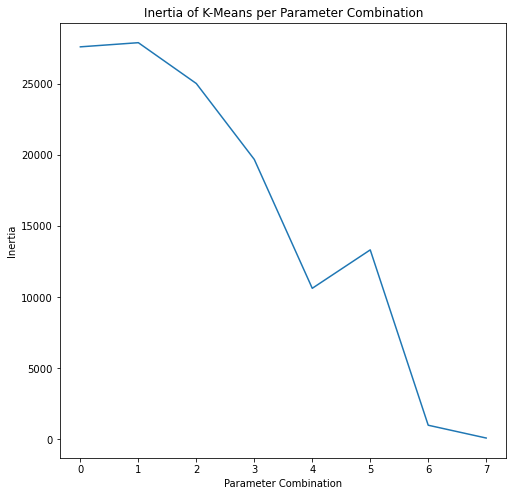

In [49]:
#Plot the inertia from our fitted MiniBatchKMeans() to find the combination of parameters (k-clusters and batch sizes) that results in the lowest inertia
fig, ax = plt.subplots(figsize = (8, 8))

sns.lineplot(range(len(lmkm_xval)), lmkm_inert)
plt.title('Inertia of K-Means per Parameter Combination')
plt.xlabel('Parameter Combination')
plt.ylabel('Inertia')

x_ticks = np.arange(0, 8, 1)
plt.xticks(x_ticks)

plt.show()

In [50]:
opt_params = MiniBatchKMeans(batch_size=250, n_clusters=50, n_init=10, random_state=42)

In [51]:
opt_kmeans = opt_params.fit(all_features)

In [52]:
all_features['cluster'] = opt_kmeans.labels_

In [53]:
all_features['is_spam'] = all_features.is_spam.astype('category')

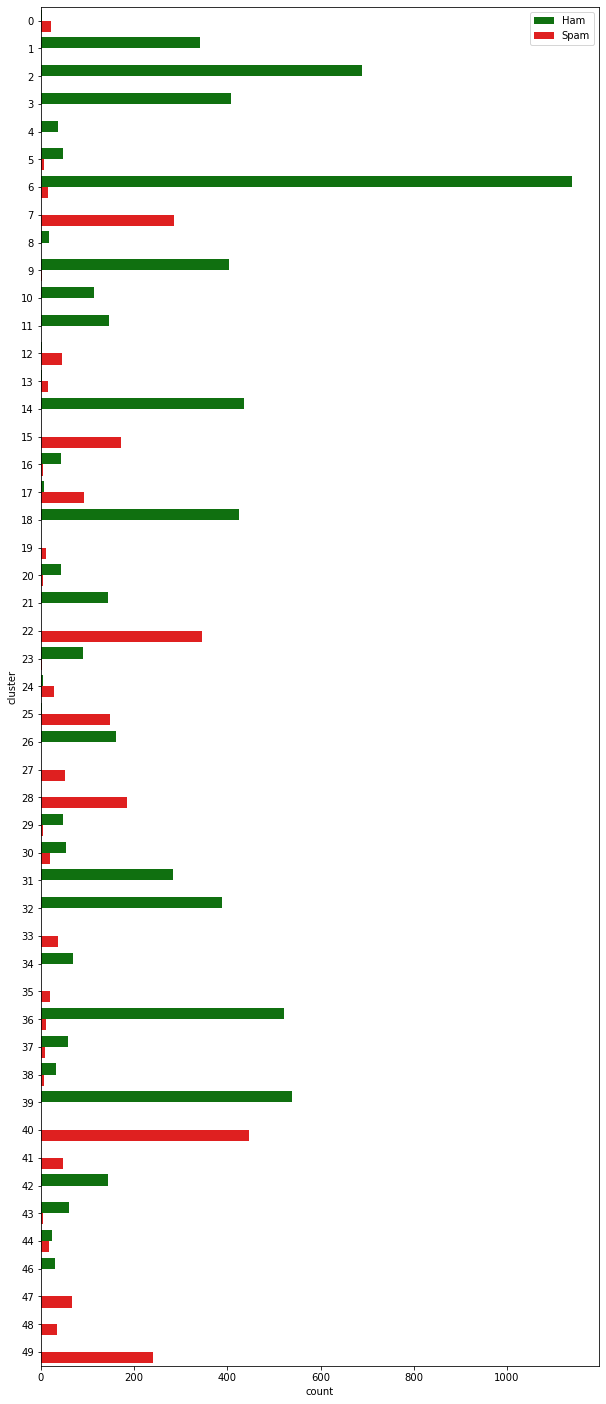

In [54]:
fig, ax = plt.subplots(figsize = (10, 25))
sns.countplot(y = all_features.cluster, hue = all_features.is_spam, palette = ["green", "red"])
ax.legend(title = None , labels = ["Ham", "Spam"])

#### Interpretation
The above chart shows a comparison of the word cound from each of the 50 clusters, color coded by whether the words were from a spam or ham email. The chart is a little unweildly, but you can see that the clusters tend to be well distinguished from each other in this regard - clusters with word counts from ham emails tend to have little to no word counts from spam emails and vice versa. Additionally the clusters may have been formed in part by email length - grouping the more verbose emails into a cluster together. 

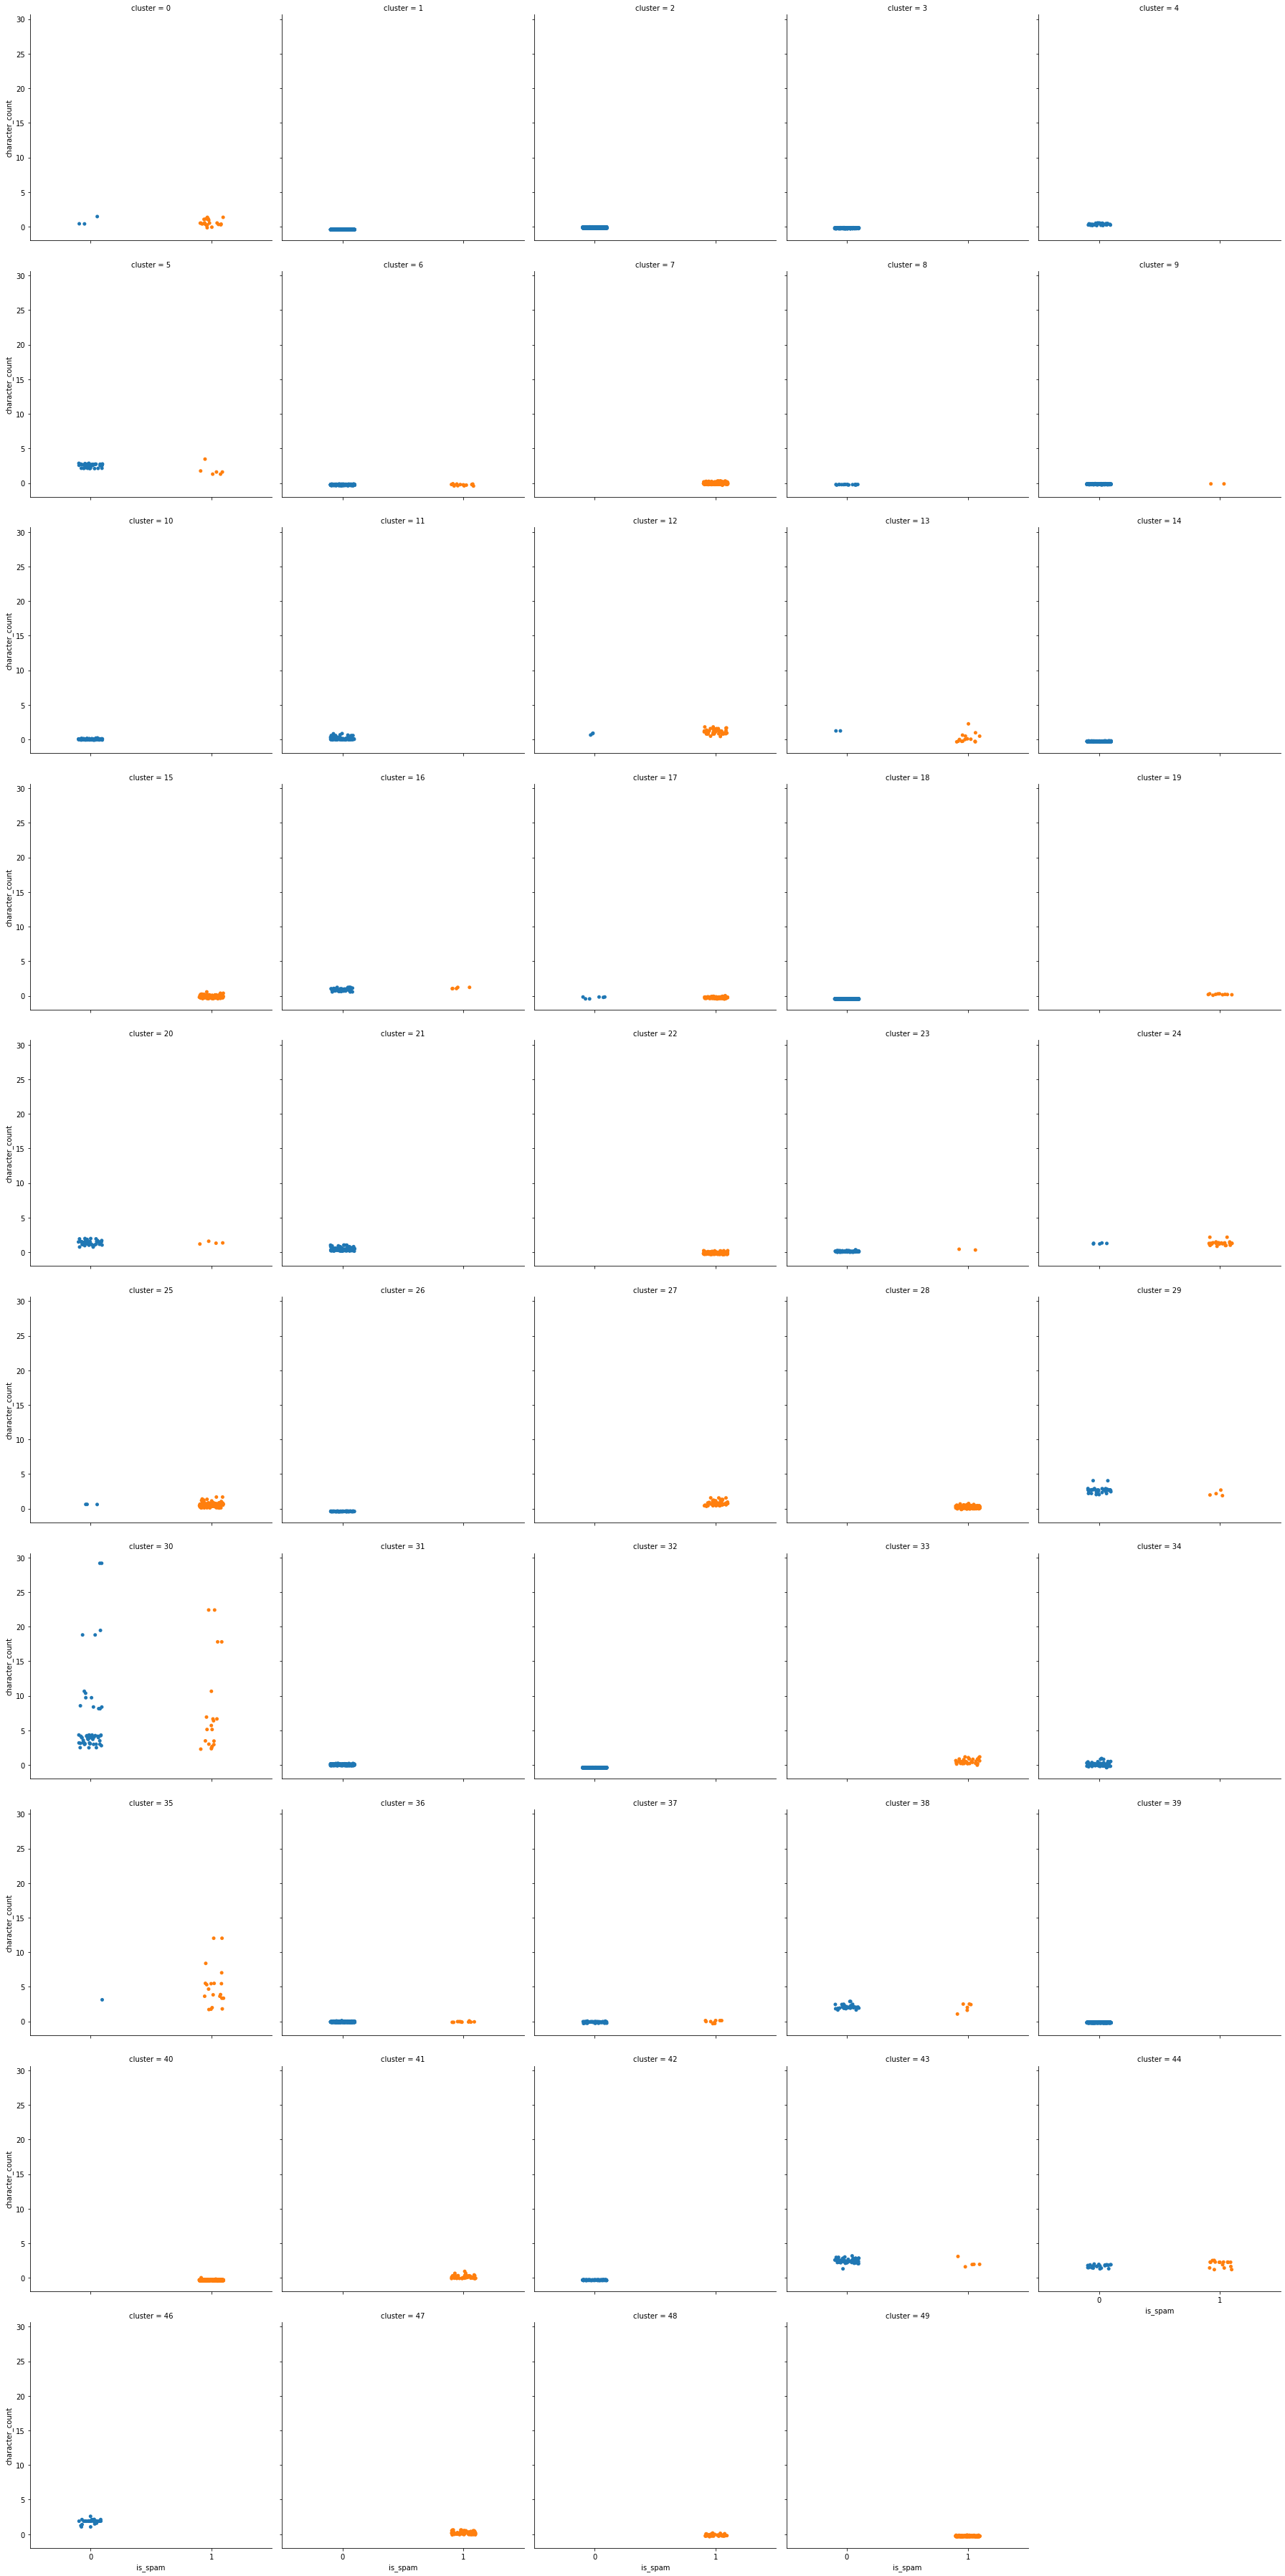

In [55]:
sns.catplot(data = all_features, x = "is_spam", y = "character_count", col = "cluster", col_wrap = 5)

plt.show()

#### Interpretation
The chart above displays each of the 50 clusters in its own plot, with two columns for ham vs spam, with character count on the y-axis. Unfortunately the visual as a whole suffers from extreme outliers on two of the plots, rendering the distribution of the other plots difficult to see, but this can still be a helpful visual nonetheless. Similar to the first graph, we can see that where there are occurances of spam, there is little ham in a cluster and vice versa. Although it's difficult to see, upon careful inspection, the clusters are tight around a specific character count per plot, with the exception of the two plots with extreme outliers. Those two clusters appear to be almost a catch-all for outliers, and in a more extensive exploration they would warrent closer inspection to determine why they were so difficult to place. Perhaps the main feature that cluster is formed on has no correlation with word count at all. Without taking a look at the text files in that cluster or doing some form of MLP, we cannot know. That is one of the main drawbacks to this form of unsupervised clustering. 

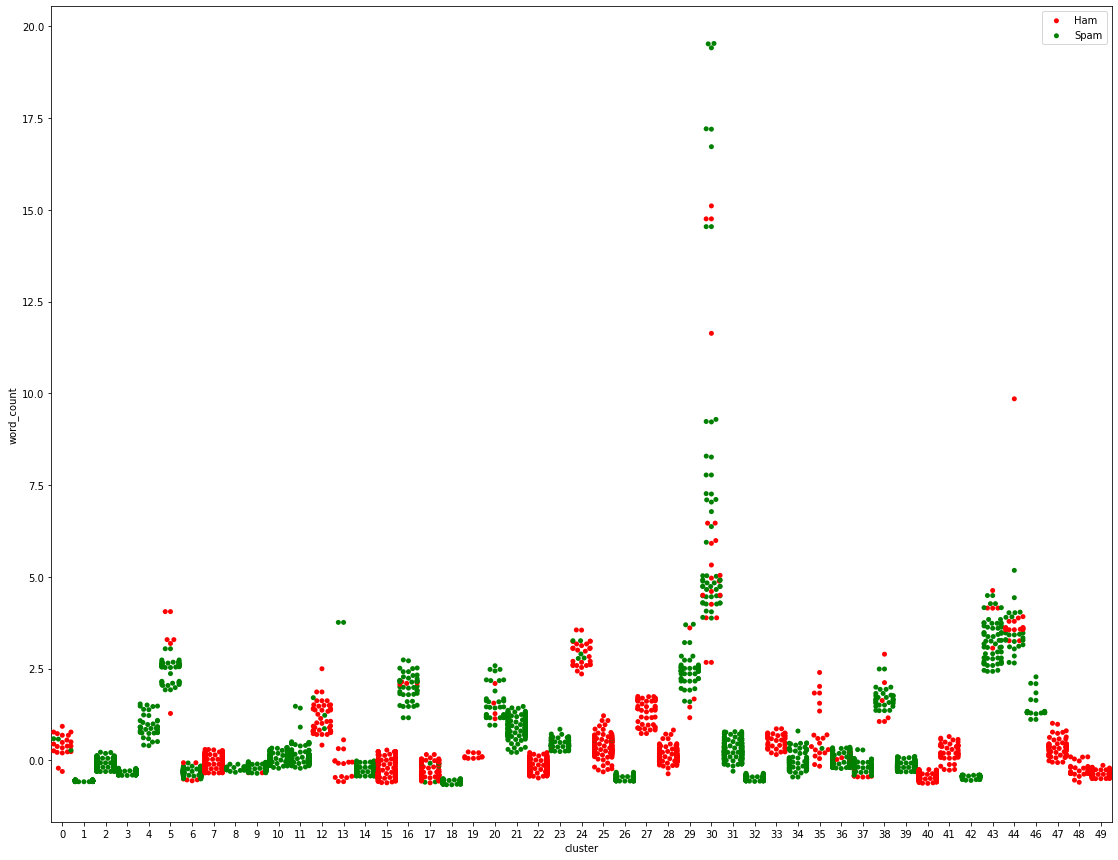

In [56]:
fig, ax = plt.subplots(figsize = (19, 15))
sns.swarmplot(all_features.cluster, all_features.word_count, hue = all_features.is_spam, palette = ["green", "red"])
ax.legend(title = None , labels = ["Ham", "Spam"])

#### Interpretation
This plot shows each cluster broken down again by word count, with the color representing whether an email is ham or spam. This chart is interesting because we are able to visualize the homogeneity of each cluster and easily see the distribution of the word count. 

### Clustering Conclusion
KMeans clustering is great for determining associations between groups of data that are too complex for humans to see. Although the data available to us was less clustered than desirable for this method, it's clear to see how useful this method can be to  understand unstructured data and support further analysis. 

## Naive Bayes Models

For our Naive Bayes models, we ran one directly on the cleaned text data, while the second one drew upon the TF-IDF and KMeans processing. Evaluation and comparison of both models will be in the conclusion of the section.

## Naive Bayes With No Pre Processing

In [87]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score, accuracy_score

In [70]:
gnb = GaussianNB()

In [71]:
gnb.fit(x_train_features.toarray(),y_train)

GaussianNB()

In [72]:
gnb.score(x_train_features.toarray(),y_train)

0.9955260977630489

In [73]:
gnb.score(x_test_features.toarray(),y_test)

0.9637176938369781

In [74]:
y_predict = gnb.predict(x_test_features.toarray())

In [75]:
conf_matrix = confusion_matrix(y_test,y_predict)
conf_matrix

array([[1656,   23],
       [  50,  283]], dtype=int64)

In [76]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[1656   23]
 [  50  283]]


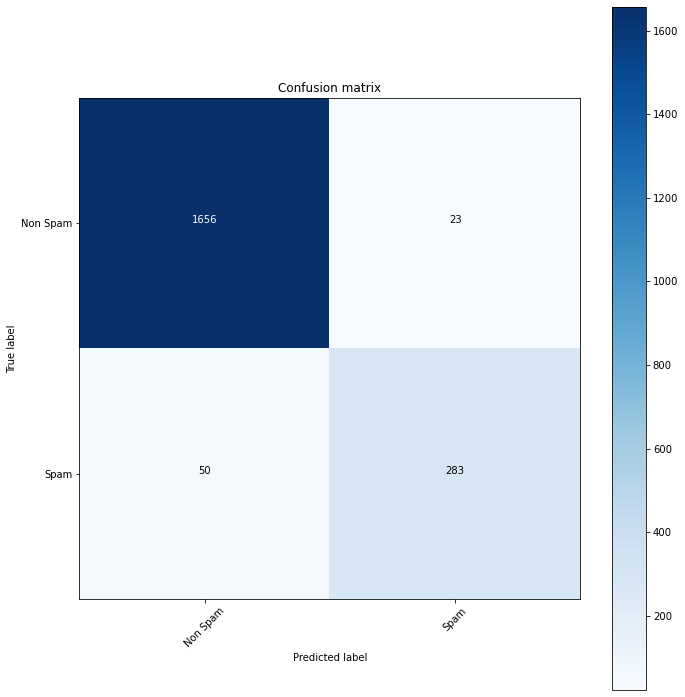

In [77]:
plt.figure(figsize = (10,10))
plot_confusion_matrix(conf_matrix, classes=['Non Spam','Spam'], normalize=False,title='Confusion matrix')
plt.show()

In [88]:
print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_test, y_predict)) )
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_predict)))

Accuracy: 96.37%
Precision: 92.48%
Recall: 84.98%


## Naive Bayes With TF-IDF and KMeans

In [128]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score

In [129]:
gnb = GaussianNB()

In [130]:
kmk_opt = MiniBatchKMeans(batch_size = 500, n_clusters = 1000, n_init=10, random_state=42)

In [131]:
kmk_feat_train = kmk_opt.fit_predict(x_train_features)
kmk_train = kmk_feat_train.reshape(-1, 1)

In [132]:
kmk_feat_test = kmk_opt.fit_predict(x_test_features)
kmk_test = kmk_feat_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [134]:
gnb.fit(kmk_train,y_train)

GaussianNB()

In [135]:
gnb.score(kmk_train,y_train)

0.8336371168185585

In [136]:
gnb.score(kmk_test,y_test)

0.834493041749503

In [137]:
y_predict = gnb.predict(kmk_test)

In [138]:
conf_matrix = confusion_matrix(y_test,y_predict)
conf_matrix

array([[1679,    0],
       [ 333,    0]], dtype=int64)

Confusion matrix, without normalization
[[1679    0]
 [ 333    0]]


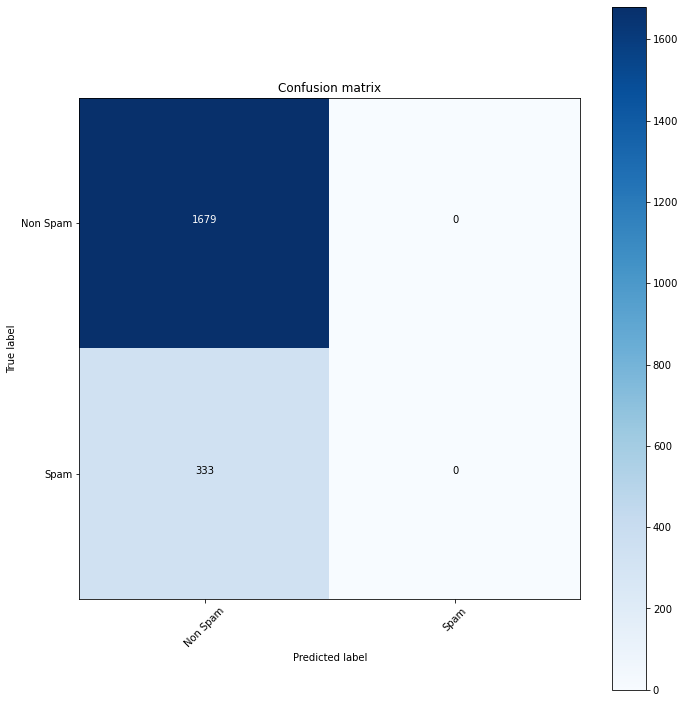

In [139]:
plt.figure(figsize = (10,10))
plot_confusion_matrix(conf_matrix, classes=['Non Spam','Spam'], normalize=False,title='Confusion matrix')
plt.show()

In [140]:
print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_test, y_predict)) )
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_predict)))

Accuracy: 83.45%
Precision: 0.00%
Recall: 0.00%


### Naive Bayes Conclusion

No Pre-Processing:   
Accuracy: 96.37%   
Precision: 92.48%   
Recall: 84.98%   

With Pre Processing:   
Accuracy: 83.45%   
Precision: 0.00%   
Recall: 0.00%   


Unfortunately as you can see, our more complex model that utilized KMeans with 1000 clusters failed to provide a useful model since it ignored spam emails and just allowed all emails to pass through as ham. This resulted in 83% accuracy but 0 precision and recall. Our basic naive bayes model with no preprocessing had a fairly accurate correct prediction rate of 96%, with precision and recall at a solid 92% and 85% respectively. 

# <font color='blue'>Case Conclusions</font>

- After all of your technical analysis and modeling; what are you proposing to your audience and why?   
    - We propose to use a naive bayes classification model for the quickest implementation for a spam filter. However, for deeper insight into spam types and perhaps an even more accurate filter, it's worth considering building off the insights provided by KMeans clustering and digging deeper into some of the clusters.   
       
- How should they view your results and what should they consider when moving forward?
    - They should consider that 96% accuracy is pretty good, but that means they will still recieve on average 2-3 spam emails into their inbox per 100 emails, and about 1 important message per 100 emails could be misclassified as spam. The management team should weigh the cost of devoting additional resources to improving the accuracy versus the *potential* benefit of having no important emails going to spam and only 1-2 spam emails per 100. 
- Are there other approaches you'd recommend exploring?
   - Since the accuracy of the filter is so high already, there may be diminishing returns to explore this further. The only thing that may make it even more accurate is taking some time to further clean the text data - our analysis used the entire email, including metadata. Being able to isolate only the actual conversation would possibly help the analysis.   
- This is where you "bring it all home" in language they understand.
    - Through our analysis we generated valuable insight into key differences between spam emails and real emails, and tested several different types of models. In the end, the best one was fairly simple and it would be hard to improve upon short of natural language processing. 